In [1]:
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings(action='ignore')
from os.path import isfile
import pickle
from sklearn.feature_extraction.text import TfidfVectorizer
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

In [3]:
questions = pd.read_csv('data/processed.csv') #for Windows should pass encoding='ISO-8859-1' as argument

In [13]:
print("Total number of questions: ", questions.content.size)

Total number of questions:  309478


In [14]:
questions.content[:9]

0                               what is spacing
1                    where can i get dairy goat
2                            purple tea farming
3                  where can i get a dairy goat
4                    where will i get dairy cow
5                where do i get broiler chicken
6      what is the spacing of kales on planting
7    what is the spacing of trees when planting
8                        how can i feed chicken
Name: content, dtype: object

#### Quick corpus analysis

In [5]:
import spacy
import en_core_web_sm
warnings.filterwarnings(action='ignore')

nlp = spacy.load('en_core_web_sm')

In [6]:
def preprocess(sentence, lemmatise):
    # NLP pipeline requires texts in Unicode as input 
    # Converting text to Unicode here helps preventing getting errors in later stages
    text = nlp(sentence)
        # unicode(open(filename).read().decode('utf8'))
        # Add flexibility to your program – either get the lowercased tokens or lemmas
    if lemmatise=="on":
        lemmas = [text[i].lemma_ for i in range(len(text))]
        #pos = [text[i].pos_ for i in range(len(text))]
        return lemmas #, pos
    else:
        tokens = [str(text[i]).lower() for i in range(len(text))]
        return tokens                   

In [147]:
corpus = [preprocess(content, "on") for content in questions.content]
corpus[:5]

[['what', 'be', 'space'],
 ['where', 'can', 'i', 'get', 'dairy', 'goat'],
 ['purple', 'tea', 'farming'],
 ['where', 'can', 'i', 'get', 'a', 'dairy', 'goat'],
 ['where', 'will', 'i', 'get', 'dairy', 'cow']]

In [166]:
#lexical richness in the questions 
total = [corp for subcorp in corpus for corp in subcorp if corp != 'i'] #total words excluding 'I' 
total_length = len(total)
unique_words = set(total)
print ("Total length " + str(total_length))
unique_words_set = set(unique_words)
print ("Unique words " + str(len(unique_words_set)))
lexical_richness = 100 * round(float(len(unique_words_set))/float(total_length), 4)
print ("Lexical richness " + str(lexical_richness) + "%")

Total length 3416943
Unique words 107082
Lexical richness 3.1300000000000003%


3.1 is quite low, meaning the corpus includes quite a lot of repetitive words 

The top $50$ most frequent words:

In [184]:
import operator

def collect_percentage_map(file_dict, up_to):
    word_map = {}
    total_count = 0
    for a_word in total:
        word_map[a_word] = word_map.get(a_word, 0) + 1
        total_count += 1
    sorted_map = (sorted(word_map.items(), key=operator.itemgetter(1)))[::-1]
    percentage_map = [(item[0], 100*float(item[1])/float(total_count)) for item in sorted_map[:up_to]]
    return percentage_map

freq = collect_percentage_map(corpus, 50)
print(freq)

[('be', 4.856855967453949), ('-PRON-', 4.268903519900683), ('to', 3.2354944170856816), ('the', 3.0370714407585964), ('of', 2.638293937007436), ('can', 2.425296529675795), ('what', 2.2242396200346333), ('in', 2.1344810258760534), ('how', 1.9742793485287873), ('do', 1.658061021211065), ('a', 1.5118191904284033), ('which', 1.5075756312001694), ('and', 1.4434539879652661), ('for', 1.3319508110027003), ('good', 1.1706662944040915), ('have', 0.9532789982156565), ('plant', 0.8649251684912508), ('chicken', 0.708001274823724), ('get', 0.6963827023160761), ('use', 0.6904417193965483), ('maize', 0.5973468097068052), ('that', 0.5916106882672612), ('where', 0.5644226432808508), ('on', 0.5638665906923235), ('cow', 0.4712692017396837), ('from', 0.45186589299265456), ('type', 0.4333112960912722), ('start', 0.4318187338799623), ('farm', 0.40237721261373105), ('one', 0.40223088298517123), ('with', 0.4002993318881819), ('tomato', 0.3873052608720719), ('want', 0.3833836268266693), ('grow', 0.3696579076677

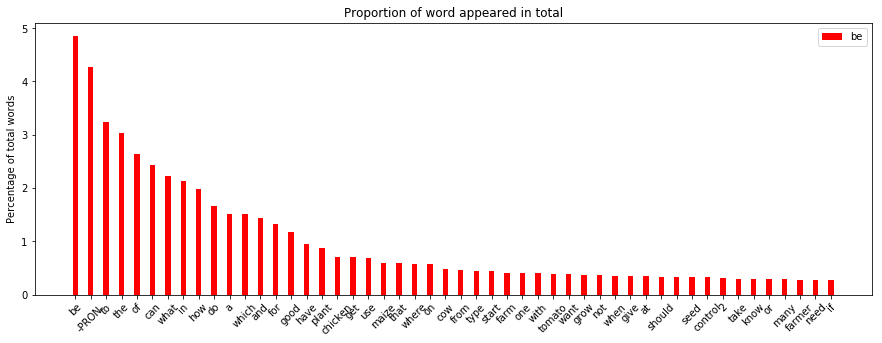

In [190]:
import matplotlib.pyplot as plt
%matplotlib inline

freq_words, percent =[], []
for item in freq:
    freq_words.append(item[0])
    percent.append(round(item[1], 4))
    
N = len(freq_words)
ind = np.arange(N)  # x locations for the word_freqs
width = 0.35      # width of the bars
fig, ax = plt.subplots()
fig.set_figheight(5)
fig.set_figwidth(15)

ax.set_ylabel('Percentage of total words')
ax.set_title('Proportion of word appeared in total')
ax.set_xticks(ind + width)
xtickNames = ax.set_xticklabels(labels=freq_words)
plt.setp(xtickNames, rotation=45, fontsize=10)
ax.legend(freq_words)
plt.show()

Note: The majority of the high frequency words in the above figure are stopwords which we will deal with below before training models

### Tokenization and lemmatization with spacy by defining content specific stopwords

In [10]:
spacy_stopwords = ['a', 'about', 'above', 'across', 'after', 'afterwards', 'again', 'against', 'all', 'almost', 
             'alone', 'along', 'already', 'also', 'although', 'always', 'am', 'among', 'amongst', 'amount', 'an', 
             'and', 'another', 'any', 'anyhow', 'anyone', 'anything', 'anyway', 'anywhere', 'are', 'around', 'as', 
             'at', 'back', 'be', 'became', 'because', 'become', 'becomes', 'becoming', 'been', 'before', 'beforehand', 
             'behind', 'being', 'below', 'beside', 'besides', 'between', 'beyond', 'both', 'bottom', 'but', 'by', 
             'ca', 'call', 'can', 'cannot', 'could', 'did', 'do', 'does', 'doing', 'done', 'down', 'due', 'during', 
             'each', 'eight', 'either', 'eleven', 'else', 'elsewhere', 'empty', 'enough', 'even', 'ever', 'every', 
             'everyone', 'everything', 'everywhere', 'except', 'few', 'fifteen', 'fifty', 'first', 'five', 'for', 
             'former', 'formerly', 'forty', 'four', 'from', 'front', 'full', 'further', 'give', 'go', 'had', 
             'has', 'have', 'he', 'hence', 'her', 'here', 'hereafter', 'hereby', 'herein', 'hereupon', 'hers', 
             'herself', 'him', 'himself', 'his', 'however', 'hundred', 'i', 'if', 'in', 'indeed', 'into', 
             'is', 'it', 'its', 'itself', 'just', 'last', 'latter', 'latterly', 'least', 'less', 'made', 
             'make', 'many', 'may', 'me', 'meanwhile', 'might', 'mine', 'more', 'moreover', 'most', 'mostly', 
             'move', 'much', 'must', 'my', 'myself', 'name', 'namely', 'neither', 'never', 'nevertheless', 'next', 
             'nine', 'no', 'nobody', 'none', 'noone', 'nor', 'not', 'nothing', 'now', 'nowhere', 'of', 'off', 'often',
             'on', 'once', 'one', 'only', 'onto', 'or', 'other', 'others', 'otherwise', 'our', 'ours', 'ourselves', 
             'out', 'over', 'own', 'part', 'per', 'perhaps', 'please', 'put', 'quite', 'rather', 're', 'really', 
             'regarding', 'same', 'say', 'see', 'seem', 'seemed', 'seeming', 'seems', 'serious', 'several', 'she', 
             'should', 'show', 'side', 'since', 'six', 'sixty', 'so', 'some', 'somehow', 'someone', 'something', 
             'sometime', 'sometimes', 'somewhere', 'still', 'such', 'take', 'ten', 'than', 'that', 'the', 'their', 
             'them', 'themselves', 'then', 'thence', 'there', 'thereafter', 'thereby', 'therefore', 'therein', 
             'thereupon', 'these', 'they', 'third', 'this', 'those', 'though', 'three', 'through', 'throughout', 
             'thru', 'thus', 'to', 'together', 'too', 'top', 'toward', 'towards', 'twelve', 'twenty', 'two', 'under', 
             'unless', 'until', 'up', 'upon', 'us', 'used', 'using', 'various', 'very', 'via', 'was', 'we', 'well', 
             'were', 'what', 'whats', 'whatever', 'whence', 'whenever', 'whereafter', 'whereas', 'whereby', 
             'wherein', 'whereupon', 'wherever', 'whether', 'which', 'while', 'whither', 'who', 'whoever', 'whole', 
             'whom', 'whose', 'will', 'with', 'within', 'without', 'would', 'yet', 'you', 'your', 'yours', 
             'yourself', 'yourselves']

farmers = ['2b', 'abt', 'acre', 'acres', 'acare', 'advice', 'advise', 'advisable', 'afarmer', 'afarm', 'agood', 
             'akg', 'akilo', 'alot', 'answer', 'ar', 'ask', 'assist', 'attack', 'av', 'b', 'b4', 'bill', 'bt', 'cal',
             'cn', 'co', 'coz', 'cry', 'da', 'dat', 'david', 'de', 'dear', 'don', 'describe', 'detail', 'du', 'e', 
             'en', 'etc', 'f', 'farm', 'farmer', 'farming', 'fellow', 'fill', 'find', 'fo', 'fr', 'ft', 'g', 
             'get', 'gide', 'gideon', 'giv', 'good', 'gr', 'gud', 'guide', 'gv', 'gve', 'ha', 'hacre', 'hav', 
             'hectare', 'hectares', 'hello', 'help', 'hey', 'hi', 'hii', 'how', 'hv', 'hve', 'hw', 'iam', 'ican', 
             'ido', 'ie', 'iget', 'ihave', 'inc', 'ineed', 'inorder', 'interest', 'irish', 'isit', 'ive', 'iwant', 
             'iwil', 'iwill', 'iwould', 'iz', 'j', 'john', 'jwant', 'kan', 'keep', 'kg', 'kgs', 'kilo', 'kilogram', 
             'kilos', 'kindly', 'km', 'know', 'knw', 'ksh', 'kshs', 'l', 'like', 'likely', 'liter', 'litre', 'look', 
             'lot', 'lt', 'ltd', 'ltr', 'lyk', 'm', 'ma', 'mean', 'message', 'mi', 'mill', 'n', 'na', 'need', 'no', 
             'nt', 'number', 'ok', 'ov', 'paul', 'phone', 'phonenumber', 'pliz', 'pls', 'plz', 'question', 'r', 
             'recommend', 'reply', 'request', 'require', 'right', 's', 'send', 'sh', 'shall', 'shd', 'shld', 'shs', 
             'shud', 'sincere', 'somebody', 'suppose', 't', 'tat', 'te', 'tel', 'telephone', 'tell', 'th', 'tha', 
             'thank', 'thanx', 'think', 'tip', 'tnx', 'tu', 'u', 'ua', 'un', 'understand', 'ur', 'wait', 'want', 
             'wat', 'wd', 'wot', 'wud', 'wch', 'wefarm', 'wen', 'wh', 'whch', 'when', 'where', 'wish', 'wht', 'why', 
             'wth', 'wich', 'wil', 'wt', 'x', 'ya', 'yes', 'yr', 'yrs', 'yu', 'z']

my_stopwords = spacy_stopwords + farmers


In [11]:
def spacy_tokenizer(text):
    tokes = nlp(text)
    tokens = [toke.lemma_ for toke in tokes if toke.lemma_ != "-PRON-"]
    tokens = [tok for tok in tokens if tok not in my_stopwords and re.search('[a-zA-Z]', tok)] #removing stops & digits
    return (' '.join(tokens))

In [12]:
#takes a good 45 mins to run
train = [spacy_tokenizer(content) for content in questions.content]
train[:20]

['space',
 'dairy goat',
 'purple tea',
 'dairy goat',
 'dairy cow',
 'broiler chicken',
 'spacing kale planting',
 'spacing tree plant',
 'feed chicken',
 'deworm goat',
 'control mole',
 'start rabbit',
 'potato spacing variety',
 'spacing plant potato',
 'plant tomato',
 'zero grazing requirement',
 'type rabbit',
 'potato seed',
 'garden',
 'tissue banana']

In [14]:
#saving the lemmas in the dataframe for easy access in the future 
questions['lemmas'] = train
questions.to_csv('data/_lemmas.csv')

------------

In [16]:
#accessing the lemmas 
lemmas_2 = pd.read_csv('data/_lemmas.csv') 

In [17]:
#saving the lemmas in a list for further vectorization 
lemmas_2.lemmas.fillna(value='', inplace=True, axis=0) 
train = lemmas_2.lemmas.values.tolist() 

Vectorization with tf-idf 

In [90]:
#extra stopwords applies only if analyzer=='word'. Check sklearn documentation for TfidfVectorizer

def vectorizer(docs, analyze, words, features):
    if analyze == 'on':
        vectorizer = TfidfVectorizer(max_features=features, analyzer='word', stop_words=words) 
        X = vectorizer.fit_transform(docs)
    else:
        vectorizer = TfidfVectorizer() 
        X = vectorizer.fit_transform(docs)
    print(X.shape)
    return X, vectorizer

In [92]:
X2, vectorizer2 = vectorizer(train, 'off', words=None, features=None)

(309478, 100232)


In [64]:
#more words to be removed as stopwords for vec3 and vec4
stops = ['stop', 'challenge', 'requirement', 'apply', 'aply', 'control', 'explain', 'briefly', 'contact', 'use',
         'able', 'come']

In [94]:
X3, vectorizer3 = vectorizer(train, 'on', words=stops, features=None)

(309478, 100220)


In [97]:
X4, vectorizer4 = vectorizer(train, 'on', words=stops, features=5000)

(309478, 5000)


In [22]:
#additional stopwords for vec5 and vec6
more_stops = stops + ['appropriate', 'best', 'cause', 'consider', 'correct', 'current', 'day', 'important', 
                      'importance', 'month', 'okey', 'old', 'start', 'week', 'year']

In [98]:
X5, vectorizer5 = vectorizer(train, 'on', words=more_stops, features=None)

(309478, 100205)


In [99]:
X6, vectorizer6 = vectorizer(train, 'on', words=more_stops, features=5000)

(309478, 5000)


In [ ]:
#pickling two of the vectors for reproducibility and further analysis
with open('vect_2.pickle', 'wb') as output_file:
    pickle.dump([vectorizer2], output_file)

with open('vect_4.pickle', 'wb') as output_file:
    pickle.dump([vectorizer5], output_file)
    

In [ ]:
#loading vectors from pickle file
def load_from_file(model_file):
    
    if not isfile(model_file):
        raise Exception("Did not find the serialised model at: " + model_file)

    with open(model_file, 'rb') as infile:
        (vectorizer,) = pickle.load(infile)

    return vectorizer

#replace 'file path' with the absolute file path of the file 
file = "/file path/vect_2.pickle"
vect_2 = load_from_file(file)

file = "/file path/vect_4.pickle"
vect_4 = load_from_file(file)


In [25]:
#saving the sparse tfidf vectors for reproducibility
from scipy.sparse import csr_matrix

def save_sparse_csr(filename, array):
    np.savez(filename, data=array.data ,indices=array.indices,
             indptr=array.indptr, shape=array.shape )

def load_sparse_csr(filename):
    loader = np.load(filename)
    return csr_matrix((loader['data'], loader['indices'],
                       loader['indptr']), shape=loader['shape'])

In [ ]:
#the absolute file path where the sparse vector will be saved
data_path = ''

In [27]:
save_sparse_csr(data_path + 'vect_2.npz', X2)
save_sparse_csr(data_path + 'vect_4.npz', X4)

In [28]:
sparse_vect2 = load_sparse_csr(data_path + 'vect_2.npz')
sparse_vect4 = load_sparse_csr(data_path + 'vect_4.npz')
sparse_vect2.shape, sparse_vect4.shape

((309478, 100232), (309478, 5000))

In [29]:
def df_maker(vect, data): 
    df = pd.DataFrame({'term': vect.get_feature_names(),
                       'occurrences':np.asarray(data.sum(axis=0)).ravel().tolist(),
                       'inverse_df': vect.idf_.tolist()})
    return df

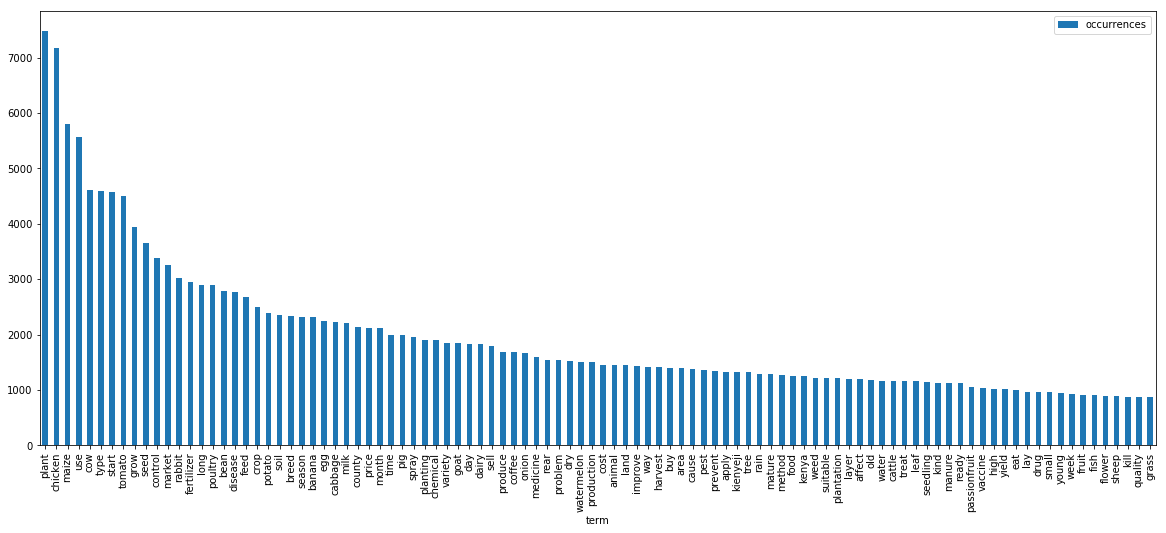

In [44]:
df = df_maker(vect_2, sparse_vect2) 
df = df.sort_values('occurrences', ascending=False)

%matplotlib inline
df[:100].plot.bar('term', 'occurrences', figsize=[20,8])

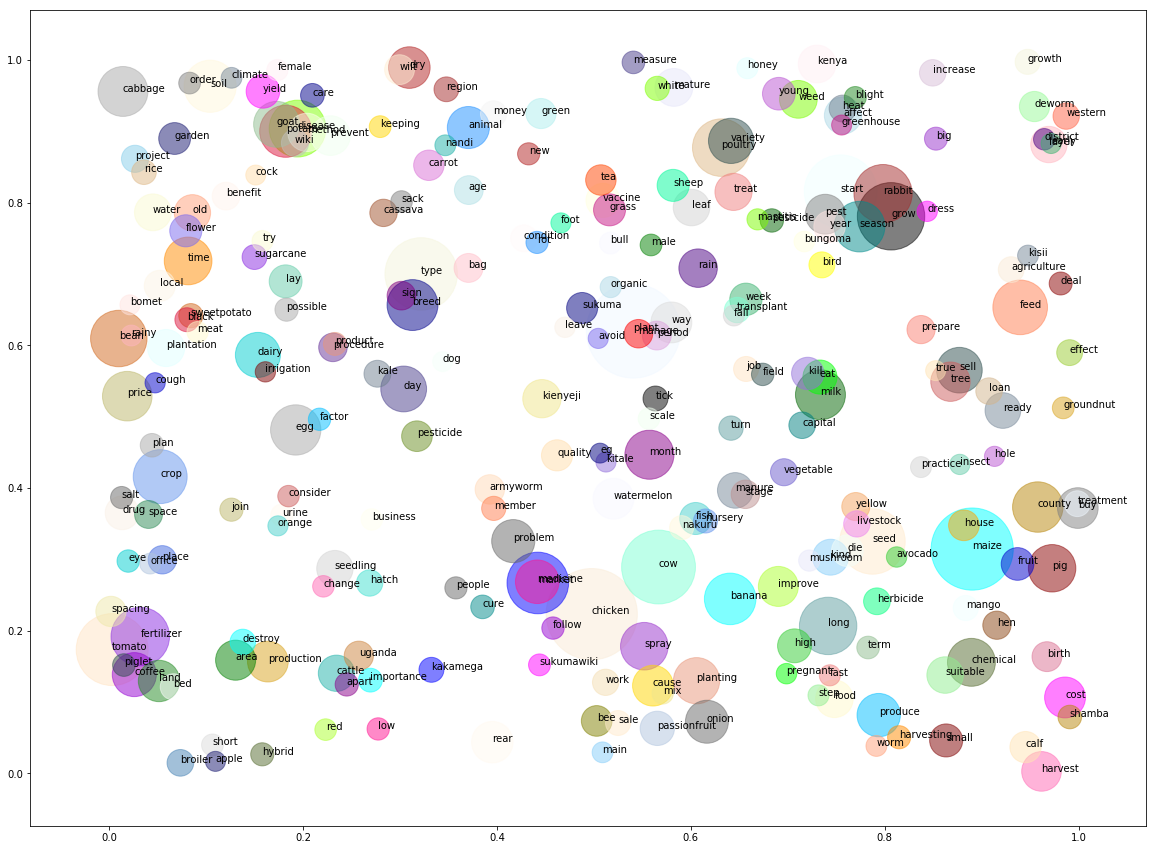

In [42]:
import matplotlib
df4 = df_maker(vect_4, sparse_vect4)
df4 = df4.sort_values('occurrences', ascending=False)
n = 250
df4 = df4[:n]

x = np.random.rand(n)
y = np.random.rand(n)
colors = []
for i in range(n):
    for name, hex in matplotlib.colors.cnames.items():
        colors.append(hex)
colormap = np.array(colors)

size = round(df4['occurrences'])  
terms = df4.term.values.tolist()

plt.figure(figsize=(20,15))
plt.scatter(x, y, s=size, c=colormap, label=terms, alpha=0.50)
for i, txt in enumerate(terms):
    plt.annotate(txt, (x[i],y[i]))

plt.show()

### Question similarity through cosine:

In [45]:
from sklearn.neighbors import NearestNeighbors

model_tf_idf2 = NearestNeighbors(metric='cosine', algorithm='brute')
model_tf_idf2.fit(sparse_vect2)

NearestNeighbors(algorithm='brute', leaf_size=30, metric='cosine',
         metric_params=None, n_jobs=1, n_neighbors=5, p=2, radius=1.0)

In [46]:
def print_nearest_neighbors(query_tf_idf, questions, knn_model, k):
    
    distances, indices = knn_model.kneighbors(query_tf_idf, n_neighbors=k+1)
    nearest_neighbors = [questions.iloc[x] for x in indices.flatten()]
    
    for neighbor in range(len(nearest_neighbors)):
        if neighbor == 0:
            print('\n* {0} *\n\nSimilar questions:\n'.format(nearest_neighbors[neighbor]))
        else:
            print('{0}: {1}\n'.format(neighbor, nearest_neighbors[neighbor]))

In [47]:
ind = np.random.choice(sparse_vect2.shape[0]) 
print_nearest_neighbors(sparse_vect2[ind], lemmas_2.content, model_tf_idf2, k=20)


* q how can i control cutwarms *

Similar questions:

1: how can i control cutwarms

2: yes i know cutwarm

3: wht is the best way for control cutwarm in the crops

4: which chemical is used to control cutwarms in cabbages

5: which is the best insectside for controling cutwarms

6: what is the appropriate way of controlling cutwarms in growing maize

7: which chemical can i use to contro cutwarm

8: iwant to knw the best chemicals tht i can use to kill cutwarms

9: which chamicals is used to kill cutwarms

10: which types of cemical can a famer used to control maize cutwarm

11: what can i do to erradicate cutwarm in my passionfruit farm

12: which medicine to we spray on maize when they are attacted by cutwarm

13: to control apecide harms like cutwarm

14: what is the name of the pesticide afamer can use to spray on is crop when there are cutwarm

15: the pest that destroy maizes leaves in our area and its looking like cutwarm do you know it

16: what can i do to my farm to kill cu

### Clustering with spacy lemmas:

In [49]:
def cluster(docs, n_clusters, n_iter, n_init):
    km = KMeans(n_clusters, init='k-means++', max_iter=n_iter, n_init=n_init, random_state=21) 
    km.fit(docs) 
    return km

In [50]:
def cluster_desc(model, vec):
    print("Top terms per cluster:")
    order_centroids = model.cluster_centers_.argsort()[:, ::-1]
    terms = vec.get_feature_names()
    for i in range(n_clusters):
        print("Cluster %d:" % i),
        for ind in order_centroids[i, :10]:
            print(' %s' % terms[ind])

In [ ]:
#describing the clusters with pickled models
def model_desc(n_clusters, *model):
    
    (kmeans, vectorizer) = model[0]
    
    print("Top terms per cluster:")
    order_centroids = kmeans.cluster_centers_.argsort()[:, ::-1]
    terms = vectorizer.get_feature_names()
    for i in range(n_clusters):
        print("Cluster %d:" % i),
        for ind in order_centroids[i, :10]:
            print(' %s' % terms[ind])

In [119]:
#for a quick cluster prediction. Use predict_model for pickeled models. 
def predict_it(sentence, km, vect):
    
    Y = vect.transform(sentence)
    predictions = km.predict(Y)
    
    order_centroids = km.cluster_centers_.argsort()[:, ::-1]
    terms = vect.get_feature_names()
    print("Cluster %d:" % predictions),
    for ind in order_centroids[int(predictions), :10]:
        print(' %s' % terms[ind]),
    return predictions

In [144]:
#predicting with pickled model
def predict_model(data, *model):

    (kmeans, vectorizer) = model[0]
    Y = vectorizer.transform(data)
    prediction = kmeans.predict(Y)
    
    order_centroids = kmeans.cluster_centers_.argsort()[:, ::-1]
    terms = vectorizer.get_feature_names()
    print("Cluster %d:" % prediction),
    for ind in order_centroids[int(prediction), :10]:
        print('  %s' % terms[ind])
    return prediction

In [111]:
km_2 = cluster(X2, 100, 100, 5) #100 clusters
n_clusters = 100
cluster_desc(km_2, vectorizer2)

Top terms per cluster:
Cluster 0:
 sabaki
 bridge
 duration
 rain
 long
 flock
 flo
 floack
 fload
 floak
Cluster 1:
 apply
 fertilizer
 maize
 stage
 tomato
 type
 plant
 chemical
 time
 potato
Cluster 2:
 armyworm
 control
 maize
 fall
 pesticide
 use
 chemical
 pestcide
 garden
 plantation
Cluster 3:
 cotton
 black
 soil
 plant
 grow
 seed
 type
 price
 crop
 use
Cluster 4:
 price
 maize
 current
 market
 bean
 bag
 sack
 potato
 tomato
 uganda
Cluster 5:
 provide
 securityone
 watertake
 excercise
 sponser
 sufficient
 square
 welcome
 programme
 anybody
Cluster 6:
 cold
 chicken
 area
 season
 place
 type
 weather
 use
 grow
 tomato
Cluster 7:
 cabbage
 plant
 grow
 type
 variety
 seed
 market
 spacing
 gloria
 planting
Cluster 8:
 wilt
 banana
 bacterial
 control
 bacteria
 tomato
 prevent
 cause
 plantation
 potato
Cluster 9:
 week
 chicken
 old
 die
 feed
 medicine
 problem
 food
 day
 spray
Cluster 10:
 long
 mature
 harvest
 ready
 cow
 birth
 tomato
 grow
 transplant
 plant


In [ ]:
km_3 = cluster(X3, 200, 1000, 5) #200 clusters, more stopwords than Km_2
n_clusters = 200
cluster_desc(km_3, vect_3)

In [ ]:
km_4 = cluster(X4, 300, 100, 1) #300 clusters, same stopwords as km_3, only the first top 5000 words only
n_clusters = 300
cluster_desc(km_4, vect_4)

In [116]:
km_5 = cluster(X5, 220, 500, 5) #220 clusters, more stopwords than km3 or km4
n_clusters = 220
cluster_desc(km_5, vectorizer5)

Top terms per cluster:
Cluster 0:
 young
 chicken
 rabbit
 feed
 goat
 pig
 vaccine
 die
 grow
 turkey
Cluster 1:
 armyworm
 chemical
 kill
 maize
 fall
 spray
 destroy
 plantation
 crop
 effective
Cluster 2:
 bean
 plant
 maize
 season
 fertilizer
 time
 type
 seed
 soya
 land
Cluster 3:
 banana
 seed
 plant
 sweet
 planting
 true
 type
 buy
 extablish
 posse
Cluster 4:
 chicken
 vaccine
 problem
 local
 treat
 eye
 cough
 mash
 treatment
 eat
Cluster 5:
 salt
 cow
 dairy
 milk
 type
 mineral
 lick
 cattle
 feed
 heat
Cluster 6:
 decay
 fruit
 tomato
 chemical
 prevent
 problem
 manure
 stemswhat
 fall
 watermelon
Cluster 7:
 coffee
 price
 plant
 plantation
 fertilizer
 dry
 type
 disease
 berry
 seedling
Cluster 8:
 deworm
 cow
 medicine
 drug
 pregnant
 long
 calf
 cattle
 sheep
 chicken
Cluster 9:
 cow
 problem
 eat
 pregnant
 friesian
 sign
 treat
 blood
 skin
 milking
Cluster 10:
 structure
 chicken
 poultry
 soil
 construct
 build
 improve
 house
 rear
 layer
Cluster 11:
 breed

 disease
 fertilizer
 breed
 feed
 pest
 plant
 animal
 maize
Cluster 143:
 area
 arid
 type
 dry
 maize
 plant
 grow
 crop
 semi
 seed
Cluster 144:
 manage
 chicken
 poultry
 tomato
 plant
 way
 disease
 rabbit
 cabbage
 land
Cluster 145:
 groundnut
 plant
 planting
 fertilizer
 grow
 type
 soil
 season
 harvest
 long
Cluster 146:
 procedure
 follow
 plant
 planting
 grow
 tomato
 silage
 onion
 poultry
 prepare
Cluster 147:
 stress
 chicken
 poultry
 avoid
 prevent
 hen
 reduce
 flock
 bird
 layer
Cluster 148:
 care
 chicken
 young
 plant
 tomato
 pig
 rabbit
 way
 passionfruit
 coffee
Cluster 149:
 branch
 coffee
 dry
 agriculture
 county
 uganda
 plant
 office
 tree
 main
Cluster 150:
 spacing
 cabbage
 plant
 planting
 transplant
 gloria
 field
 seedling
 plantin
 measurement
Cluster 151:
 plantation
 banana
 manure
 fertilizer
 plant
 wilt
 improve
 type
 maize
 coffee
Cluster 152:
 rainbow
 rooster
 chicken
 roster
 kienyeji
 egg
 breed
 county
 kuroiler
 poultry
Cluster 153:
 l

In [ ]:
km_6 = cluster(X6, 220, 100, 5) #220 clusters, same stopwords as km_5, the first top 5000 words only
n_clusters = 220
cluster_desc(km_6, vect_6)

In [ ]:
#saving the models for reproducibility
with open('cluster_model_2.pickle', 'wb') as output_file:
    pickle.dump([km_2, vectorizer2], output_file)

with open('cluster_model_5.pickle', 'wb') as output_file:
    pickle.dump([km_5, vectorizer5], output_file)

In [ ]:
#accessing the serialised models 
def load_from_file(model_file):
    
    if not isfile(model_file):
        raise Exception("Did not find the serialised model at: " + model_file)

    with open(model_file, 'rb') as infile:
        [kmeans, vectorizer] = pickle.load(infile)

    return [kmeans, vectorizer]

file_2 = "/file path/cluster_model_2.pickle"
model_2 = load_from_file(file_2)

file_5 = "/file path/cluster_model_5.pickle"
model_5 = load_from_file(file_5)


In [142]:
(km2, vect2) = model_2 #100 clusters
(km5, vect5) = model_5 #220 clusters, and more stopwords 

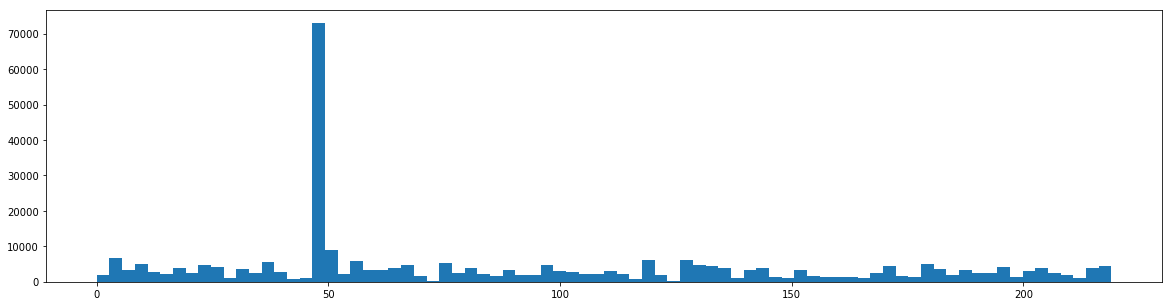

In [131]:
#showing a cluster distributions
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(20,5))
plt.hist(km5.labels_, bins=80)
plt.show()

In [133]:
def cluster_assign(model):
    cluster_assignments_dict = {}
    for i in set(model.labels_):
        current_cluster_bills = [lemmas_2.content[x] for x in np.where(model.labels_ == i)[0]]
        cluster_assignments_dict[i] = current_cluster_bills
    return cluster_assignments_dict

In [134]:
model_5_clusters = cluster_assign(km5)

In [ ]:
cluster_number = np.random.choice(len(set(km5.labels_)))
print('Cluster {0}, has {1} items'.format(cluster_number, len(model_5_clusters[cluster_number])))
#model_5_clusters[cluster_number]

Cluster 27, has 425 items

### Clustering new test questions with the generated models:

In [120]:
print("1 ->", predict_it(["how can i cure coccidiosis disease in my chicken"], km_5, vectorizer5))
print("2 ->", predict_it(["best goat breed in the county"], km_5, vectorizer5))
print("3 ->", predict_it(["is dap fertilizer recommended for planting of maize"], km_5, vectorizer5))
print("4 ->", predict_it(["my cattle produces less milk what should i do"], km_5, vectorizer5))

Cluster 129:
 coccidiosis
 poultry
 chicken
 drug
 treat
 treatment
 vaccine
 cure
 medicine
 prevent
1 -> [129]
Cluster 24:
 goat
 dairy
 milk
 breed
 sheep
 type
 produce
 price
 feed
 rear
2 -> [24]
Cluster 160:
 dap
 fertilizer
 plant
 maize
 planting
 mix
 urea
 tomato
 bean
 dressing
3 -> [160]
Cluster 170:
 milk
 cow
 minute
 feed
 increase
 type
 problem
 milking
 time
 breed
4 -> [170]


In [121]:
print("5_1 ->", predict_it(["where can i sell my rabbits"], km_5, vectorizer5))
print("5_2 ->", predict_it(["what is urine of rabbit good for"], km_5, vectorizer5))
print("5_3 ->", predict_it(['which type of rabbit is best to keep'], km_5, vectorizer5)) #type should be removed as stopwprd so should suitable
print("5_4 ->", predict_it(['how can i protect my rabbit over a certain bacteria on they ears'], km_5, vectorizer5))

Cluster 114:
 sell
 rabbit
 market
 chicken
 egg
 price
 maize
 product
 bean
 cabbage
5_1 -> [114]
Cluster 161:
 urine
 rabbit
 market
 sell
 collect
 fertilizer
 buy
 benefit
 cost
 price
5_2 -> [161]
Cluster 67:
 type
 maize
 plant
 chicken
 cow
 suitable
 vaccine
 cassava
 kenya
 cattle
5_3 -> [67]
Cluster 120:
 rabbit
 market
 type
 meat
 sale
 pregnant
 disease
 kenya
 price
 buyer
5_4 -> [120]


In [123]:
print("7 ->", predict_it(["when is the best month to fertilize maize"], km_5, vectorizer5))
print("8 ->", predict_it(['whats a good spacing for cabbage'], km_5, vectorizer5))
print("9 ->", predict_it(['how can i prevent wilt in banana'], km_5, vectorizer5))

Cluster 203:
 maize
 harvest
 worm
 stalk
 destroy
 store
 stage
 urea
 plantation
 dress
7 -> [203]
Cluster 150:
 spacing
 cabbage
 plant
 planting
 transplant
 gloria
 field
 seedling
 plantin
 measurement
8 -> [150]
Cluster 182:
 wilt
 banana
 bacteria
 prevent
 plantation
 disease
 fight
 way
 treat
 tomato
9 -> [182]


In [149]:
print("10 ->", predict_model(['to have a higher yield of kales on a small land what should i have in mind'], model_5))
print("11 ->", predict_model(['when is the best time to plant my soybeans'], model_2))
print("12 ->", predict_model(['how can i control the maize necrosis disease'], model_2))
print("13 ->", predict_model(['how should i use pesticide in tomato plantation'], model_2))
print("14 ->", predict_model(['which procedures are needed to prepare compost manure'], model_5))
print("15 ->", predict_model(['what is a good pest for armyworm'], model_5))
print("16 ->", predict_model(["my cow has a very watery dung what should I feed it"], model_5))
print("17 ->", predict_model(["how can i know when the cow is pregnant"], model_5))

Cluster 210:
  yield
  improve
  maize
  increase
  plant
  tomato
  bean
  type
  variety
  coffee
10 -> [210]
Cluster 77:
  time
  plant
  maize
  planting
  tomato
  spray
  harvest
  cow
  long
  bean
11 -> [77]
Cluster 89:
  disease
  affect
  control
  chicken
  foot
  mouth
  prevent
  poultry
  maize
  common
12 -> [89]
Cluster 33:
  plantation
  banana
  maize
  fertilizer
  use
  control
  improve
  manure
  apply
  plant
13 -> [33]
Cluster 58:
  manure
  organic
  compost
  green
  plant
  farmyard
  fertilizer
  prepare
  yard
  type
14 -> [58]
Cluster 101:
  armyworm
  maize
  pesticide
  fall
  kill
  pestcide
  insecticide
  spray
  destroy
  affect
15 -> [101]
Cluster 62:
  feed
  chicken
  cow
  type
  piglet
  poultry
  mash
  kind
  grow
  local
16 -> [62]
Cluster 9:
  cow
  problem
  eat
  pregnant
  friesian
  sign
  treat
  blood
  skin
  milking
17 -> [9]


In [150]:
print("18 ->", predict_model(['what is a good pest for armyworm'], model_5))
print("19_1 ->", predict_model(['how can i deworm my cattle'], model_5)) 
print("19_2 ->", predict_model(["whats the medicine for a cow infested with ticks"], model_5))
print("20 ->", predict_model(["what salt should I give my cow during heat time"], model_5)) 

Cluster 101:
  armyworm
  maize
  pesticide
  fall
  kill
  pestcide
  insecticide
  spray
  destroy
  affect
18 -> [101]
Cluster 8:
  deworm
  cow
  medicine
  drug
  pregnant
  long
  calf
  cattle
  sheep
  chicken
19_1 -> [8]
Cluster 26:
  medicine
  chicken
  treat
  spray
  cough
  type
  cow
  disease
  tomato
  cure
19_2 -> [26]
Cluster 5:
  salt
  cow
  dairy
  milk
  type
  mineral
  lick
  cattle
  feed
  heat
20 -> [5]


In [157]:
print("21_1 ->", predict_model(["what causes wilt in banana leave"], model_2)) 
print("21_2 ->", predict_model(["how can I stop my banana leaves form going yellow"], model_2)) #'stop' is a stopwprd
print("21_3 ->", predict_model(["my banana leaves are turning yellow why is that"], model_2))

Cluster 8:
  wilt
  banana
  bacterial
  control
  bacteria
  tomato
  prevent
  cause
  plantation
  potato
21_1 -> [8]
Cluster 80:
  stop
  eat
  sm
  chicken
  use
  egg
  rain
  cow
  destroy
  service
21_2 -> [80]
Cluster 25:
  yellow
  turn
  leaf
  maize
  bean
  colour
  problem
  cause
  plant
  change
21_3 -> [25]


In [166]:
print("22_2 ->", predict_model(["my maize is not yellow what has happened to it"], model_5)) 

Cluster 36:
  yellow
  turn
  leaf
  bean
  maize
  colour
  problem
  plant
  change
  disease
22_2 -> [36]


In [164]:
print("23_1 ->", predict_model(["what is the current price of coffee"], model_5)) 
print("23_1 ->", predict_model(["what is the price per bag of coffee"], model_5)) #'bag' is a stopword here
print("23_2 ->", predict_model(["what is the price per bag of coffee"], model_2))  

Cluster 7:
  coffee
  price
  plant
  plantation
  fertilizer
  dry
  type
  disease
  berry
  seedling
23_1 -> [7]
Cluster 134:
  bag
  maize
  potato
  harvest
  price
  land
  bean
  produce
  sell
  cost
23_1 -> [134]
Cluster 87:
  coffee
  plant
  price
  plantation
  dry
  grow
  type
  disease
  control
  tree
23_2 -> [87]


In [161]:
print("24_1 ->", predict_model(['whats the importance of soil color'], model_2)) #'importance' 
print("24_2 ->", predict_model(['whats a good soil color'], model_2)) #no 'importance'

Cluster 48:
  soil
  type
  ph
  fertility
  plant
  grow
  improve
  suitable
  crop
  clay
24_1 -> [48]
Cluster 48:
  soil
  type
  ph
  fertility
  plant
  grow
  improve
  suitable
  crop
  clay
24_2 -> [48]
